In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa.xlsx', sheet_name= "Sheet1")
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [3]:
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001


In [4]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.10
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 5 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.297814,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.282718,227,ABEV3.SA,-0.026404,0.518242,-1.0
2,2000-01-07,0.494478,0.494478,0.494478,0.494478,0.282718,151,ABEV3.SA,0.000000,0.515865,-1.0
3,2000-01-10,0.494478,0.494478,0.494478,0.494478,0.282718,1516,ABEV3.SA,0.000000,0.513727,1.0
4,2000-01-11,0.494478,0.494478,0.494478,0.494478,0.282718,3791,ABEV3.SA,0.000000,0.511802,1.0


#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [5]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.297814,985,ABEV3.SA,NaN,0.520882,-1.0
6203,2024-09-16,12.760000,12.870000,12.750000,12.860000,12.860000,20765800,ABEV3.SA,0.130000,12.876890,NaN
6204,2024-09-17,12.790000,12.990000,12.790000,12.960000,12.960000,26068700,ABEV3.SA,0.100000,12.885201,NaN
6205,2024-09-18,12.860000,13.140000,12.850000,12.980000,12.980000,26897100,ABEV3.SA,0.020000,12.894681,NaN
6206,2024-09-19,13.000000,13.110000,12.890000,12.950000,12.950000,44713200,ABEV3.SA,-0.030000,12.900213,NaN
6207,2024-09-20,12.960000,13.000000,12.730000,12.760000,12.760000,41412300,ABEV3.SA,-0.190000,12.886191,NaN
6208,2024-09-23,12.700000,12.860000,12.650000,12.750000,12.750000,20009400,ABEV3.SA,-0.010000,12.872572,NaN
6209,2024-09-24,12.790000,12.900000,12.690000,12.760000,12.760000,22598600,ABEV3.SA,0.010000,12.861315,NaN
6210,2024-09-25,12.780000,12.980000,12.680000,12.680000,12.680000,33524600,ABEV3.SA,-0.080000,12.843184,NaN
6211,2024-09-26,12.760000,12.870000,12.720000,12.840000,12.840000,16241400,ABEV3.SA,0.160000,12.842865,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [6]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [7]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361,55.93,59.000000,61.125143
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646,55.93,60.740002,44.280393
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872,55.93,61.250000,44.828927
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132,55.93,64.379997,35.247455
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821,55.93,65.040001,38.238942


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [8]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361,55.93,59.000000,61.125143,-38.874857
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646,55.93,60.740002,44.280393,-55.719607
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872,55.93,61.250000,44.828927,-55.171073
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132,55.93,64.379997,35.247455,-64.752545
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821,55.93,65.040001,38.238942,-61.761058


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [9]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361,55.93,59.000000,61.125143,-38.874857,-0.383743,-0.481547
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646,55.93,60.740002,44.280393,-55.719607,-0.342325,-0.453703
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872,55.93,61.250000,44.828927,-55.171073,-0.285632,-0.420088
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132,55.93,64.379997,35.247455,-64.752545,-0.190613,-0.374193
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821,55.93,65.040001,38.238942,-61.761058,-0.073699,-0.314094


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [10]:
# Período do indicador
n = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361,55.93,59.000000,61.125143,-38.874857,-0.383743,-0.481547,0.002518
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646,55.93,60.740002,44.280393,-55.719607,-0.342325,-0.453703,0.007036
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872,55.93,61.250000,44.828927,-55.171073,-0.285632,-0.420088,0.010660
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132,55.93,64.379997,35.247455,-64.752545,-0.190613,-0.374193,0.019533
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821,55.93,65.040001,38.238942,-61.761058,-0.073699,-0.314094,0.026995


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [11]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
18638,2024-09-23,57.090000,57.860001,56.599998,57.529999,57.529999,18164700,VALE3.SA,0.180000,57.806542,NaN,0.000000,0.180000,46.885361,55.93,59.000000,61.125143,-38.874857,-0.383743,-0.481547,0.002518,3108351232
18639,2024-09-24,60.209999,60.740002,59.639999,60.340000,60.340000,44910100,VALE3.SA,2.810001,58.059888,NaN,0.000000,2.810001,69.946646,55.93,60.740002,44.280393,-55.719607,-0.342325,-0.453703,0.007036,3153261332
18640,2024-09-25,60.720001,61.250000,60.419998,60.610001,60.610001,21557700,VALE3.SA,0.270000,58.314899,NaN,0.000000,0.270000,71.326872,55.93,61.250000,44.828927,-55.171073,-0.285632,-0.420088,0.010660,3174819032
18641,2024-09-26,62.599998,64.379997,62.450001,64.250000,64.250000,61449300,VALE3.SA,3.639999,58.908409,NaN,0.000000,3.639999,83.275132,55.93,64.379997,35.247455,-64.752545,-0.190613,-0.374193,0.019533,3236268332
18642,2024-09-27,64.699997,65.040001,63.169998,63.959999,63.959999,37237900,VALE3.SA,-0.290001,59.413568,NaN,0.290001,0.000000,80.202821,55.93,65.040001,38.238942,-61.761058,-0.073699,-0.314094,0.026995,3273506232


## Removendo Nans

In [12]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 18643 linhas e 22 colunas
Depois da retirada dos NaN temos 18574 linhas e 22 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-01-24,0.527474,0.527474,0.527474,0.527474,0.301583,0,ABEV3.SA,0.000000,0.515610,-1.0,0.000000,0.0,70.668652,0.481293,0.527474,74.308834,-25.691166,0.000049,-0.000458,0.007440,11683
14,2000-01-25,0.527474,0.527474,0.527474,0.527474,0.301583,0,ABEV3.SA,0.000000,0.516796,-1.0,0.000000,0.0,70.668652,0.481293,0.527474,76.877951,-23.122049,0.000329,-0.000295,0.015814,11683
15,2000-01-26,0.524178,0.524178,0.524178,0.524178,0.299699,1744,ABEV3.SA,-0.003296,0.517534,-1.0,0.003296,0.0,61.773062,0.481293,0.527474,78.476451,-21.523549,0.000582,-0.000114,0.022119,13427
16,2000-01-27,0.501104,0.501104,0.501104,0.501104,0.286506,5384,ABEV3.SA,-0.023074,0.515891,-1.0,0.023074,0.0,30.629171,0.481293,0.527474,74.918667,-25.081333,0.000666,0.000045,0.021265,8043
17,2000-01-28,0.501104,0.501104,0.501104,0.501104,0.286506,0,ABEV3.SA,0.000000,0.514412,-1.0,0.000000,0.0,30.629171,0.481293,0.527474,71.716661,-28.283339,0.000629,0.000164,0.013857,8043


In [157]:
price_data.to_csv('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/price_data.csv', index=False)

## Split dos dados

##### Teste do video 1

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
train = price_data.iloc[:-100]
test = price_data.iloc[-100:]

predictors = ['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']
model.fit(train[predictors], train['Prediction'])


RandomForestClassifier(oob_score=True, random_state=0)

In [27]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Prediction"], preds)

0.6226415094339622

In [28]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Prediction"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Prediction"], preds], axis=1)
    return combined

In [29]:
def backtest(data, model, predictors, start=3000, step=300):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [30]:
prediction = backtest(price_data, model, predictors )

In [31]:
precision_score(prediction["Prediction"], prediction["Predictions"])

0.7289982030548068

##### Video.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

##### Teste do video 2.

In [34]:
price_data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-01-24,0.527474,0.527474,0.527474,0.527474,0.301583,0,ABEV3.SA,0.0,0.515610,-1.0,0.0,0.0,70.668652,0.481293,0.527474,74.308834,-25.691166,0.000049,-0.000458,0.007440,11683
14,2000-01-25,0.527474,0.527474,0.527474,0.527474,0.301583,0,ABEV3.SA,0.0,0.516796,-1.0,0.0,0.0,70.668652,0.481293,0.527474,76.877951,-23.122049,0.000329,-0.000295,0.015814,11683


In [33]:
train = price_data.iloc[:-365]
test = price_data.iloc[-365:]

In [35]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
features_cols =  ['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']


In [38]:
clf.fit(train[features_cols], train['Prediction'])

RandomForestClassifier(oob_score=True, random_state=0)

In [39]:
clf.estimators_[10]

DecisionTreeClassifier(max_features='sqrt', random_state=626610453)

In [40]:
clf.oob_score_

0.8234938766544017

In [42]:
oob_probs = clf.oob_decision_function_[:,1]
oob_preds = np.where(oob_probs>= 0.5,1,-1)

In [43]:
confusion_matrix(train['Prediction'],oob_preds)

array([[5893, 1869],
       [1352, 9095]], dtype=int64)

In [46]:
tests_preds = clf.predict(test[features_cols])
tests_preds

array([-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1

In [44]:
test_probs = clf.predict_proba(test[features_cols])[:,1]
test_probs

array([0.1 , 0.11, 0.01, 0.01, 0.01, 0.05, 0.7 , 0.39, 0.25, 0.14, 0.05,
       0.19, 0.05, 0.05, 0.03, 0.02, 0.03, 0.04, 0.08, 0.07, 0.04, 0.02,
       0.11, 0.16, 0.23, 0.23, 0.16, 0.15, 0.25, 0.09, 0.41, 0.44, 0.16,
       0.2 , 0.  , 0.  , 0.04, 0.05, 0.05, 0.01, 0.1 , 0.08, 0.33, 0.27,
       0.24, 0.49, 0.5 , 0.17, 0.53, 0.81, 0.9 , 0.89, 0.93, 0.56, 0.41,
       0.25, 0.24, 0.32, 0.32, 0.24, 0.22, 0.25, 0.44, 0.28, 0.22, 0.22,
       0.26, 0.31, 0.62, 0.56, 0.75, 0.79, 0.76, 0.67, 0.77, 0.71, 0.79,
       0.8 , 0.9 , 0.88, 0.7 , 0.39, 0.66, 0.49, 0.42, 0.57, 0.61, 0.54,
       0.42, 0.51, 0.37, 0.38, 0.15, 0.11, 0.09, 0.13, 0.12, 0.1 , 0.44,
       0.48, 0.32, 0.26, 0.34, 0.64, 0.7 , 0.72, 0.82, 0.87, 0.8 , 0.8 ,
       0.63, 0.73, 0.63, 0.57, 0.83, 0.88, 0.72, 0.89, 0.93, 0.63, 0.76,
       0.48, 0.75, 0.59, 0.68, 0.77, 0.64, 0.47, 0.45, 0.4 , 0.6 , 0.48,
       0.6 , 0.71, 0.62, 0.74, 0.72, 0.39, 0.25, 0.2 , 0.12, 0.29, 0.38,
       0.63, 0.84, 0.8 , 0.73, 0.79, 0.96, 0.92, 0.

In [47]:
accuracy_score(test['Prediction'], tests_preds)

0.6904109589041096

##### Old.

In [212]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [213]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  81.80447889750215


In [214]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.806234,0.766798,0.786022,2024.000000
Up Day,0.826407,0.857634,0.841731,2620.000000
accuracy,0.818045,0.818045,0.818045,0.818045
macro avg,0.816320,0.812216,0.813876,4644.000000
weighted avg,0.817615,0.818045,0.817451,4644.000000


Accuracy: 0.8180447889750215
Precision: 0.8264067671938212
Recall: 0.8576335877862595
Specificity: 0.766798418972332


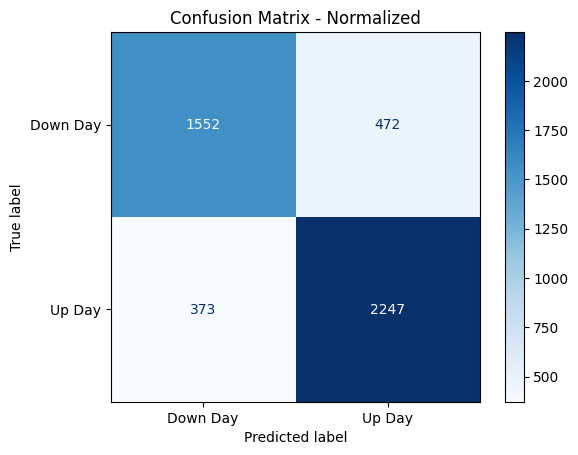

In [215]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


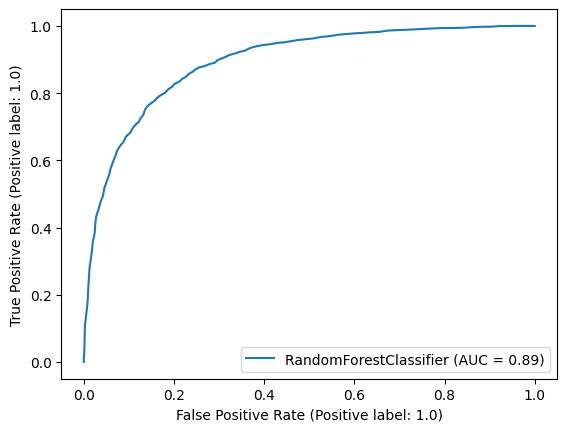

In [216]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test)
plt.show()


<Figure size 2000x1000 with 0 Axes>

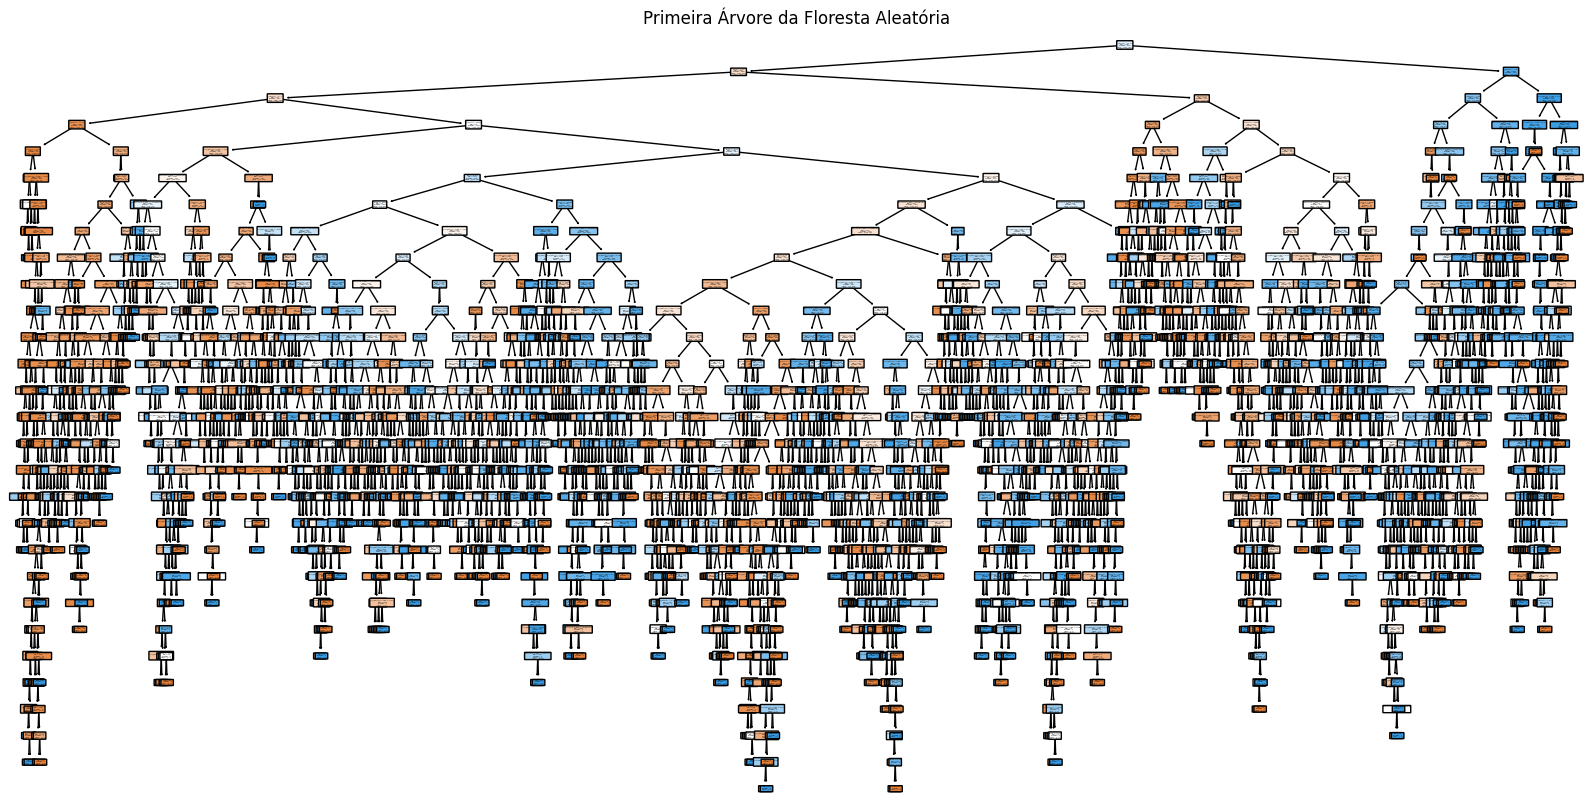

In [49]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Visualizar a primeira árvore da floresta aleatória
plt.figure(figsize=(20,10))  # Definir o tamanho da figura
plot_tree(rand_frst_clf.estimators_[0], filled=True, feature_names=X_Cols.columns, class_names=['Classe 0', 'Classe 1'], rounded=True)
plt.title('Primeira Árvore da Floresta Aleatória')
plt.show()


In [ ]:
price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']].head(50)

### Plotagem da suavição e indicador de direção da Vale. Dados reais, sem machine learning.

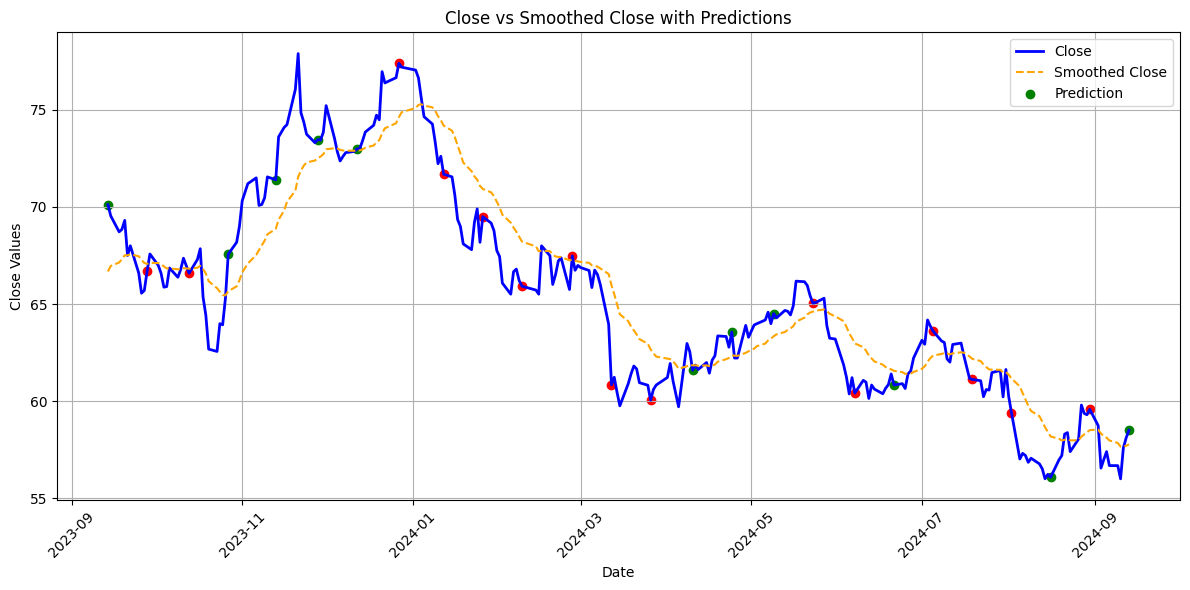

In [195]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Ambev. Dados reais, sem machine learning.

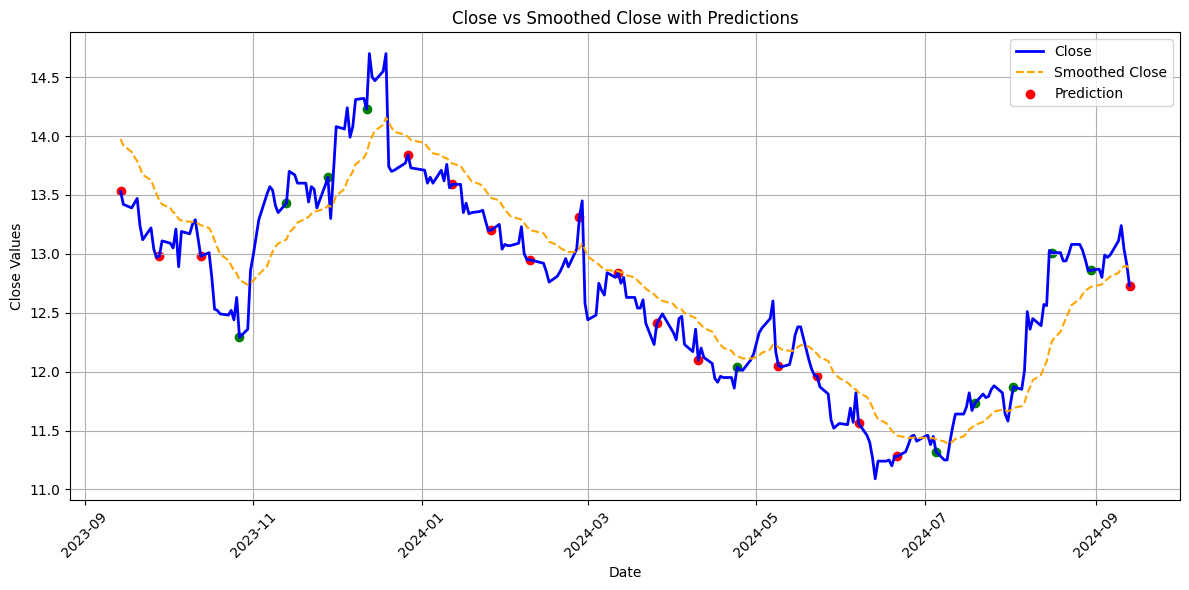

In [197]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Sabesp. Dados reais, sem machine learning.

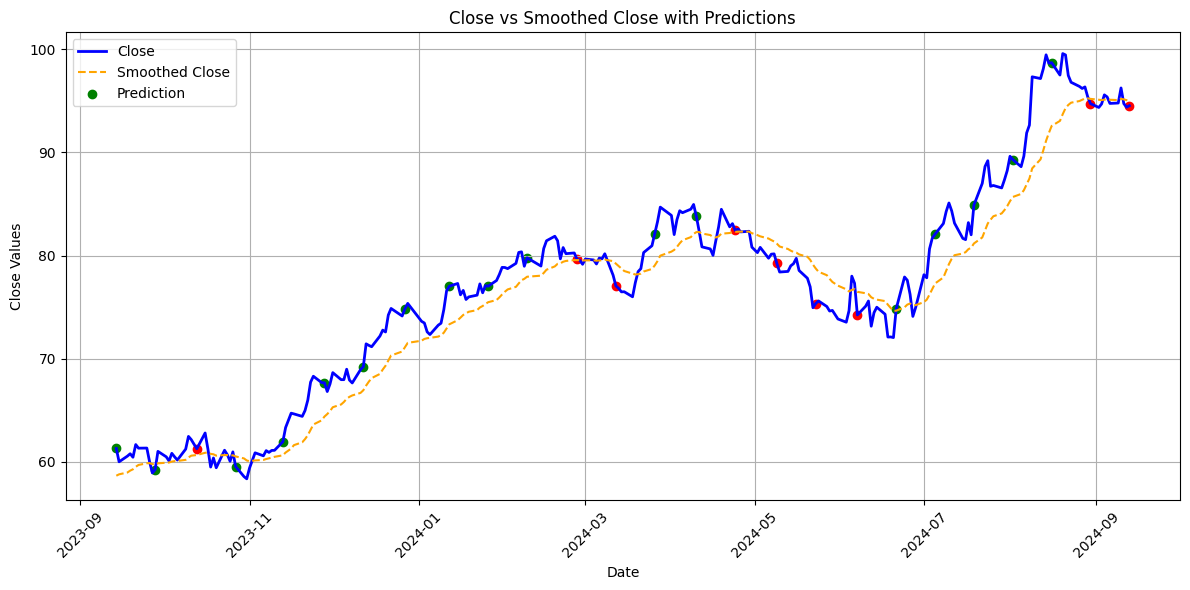

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'SBSP3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem do gráfico de Vale com predição do modelo de machine learning.

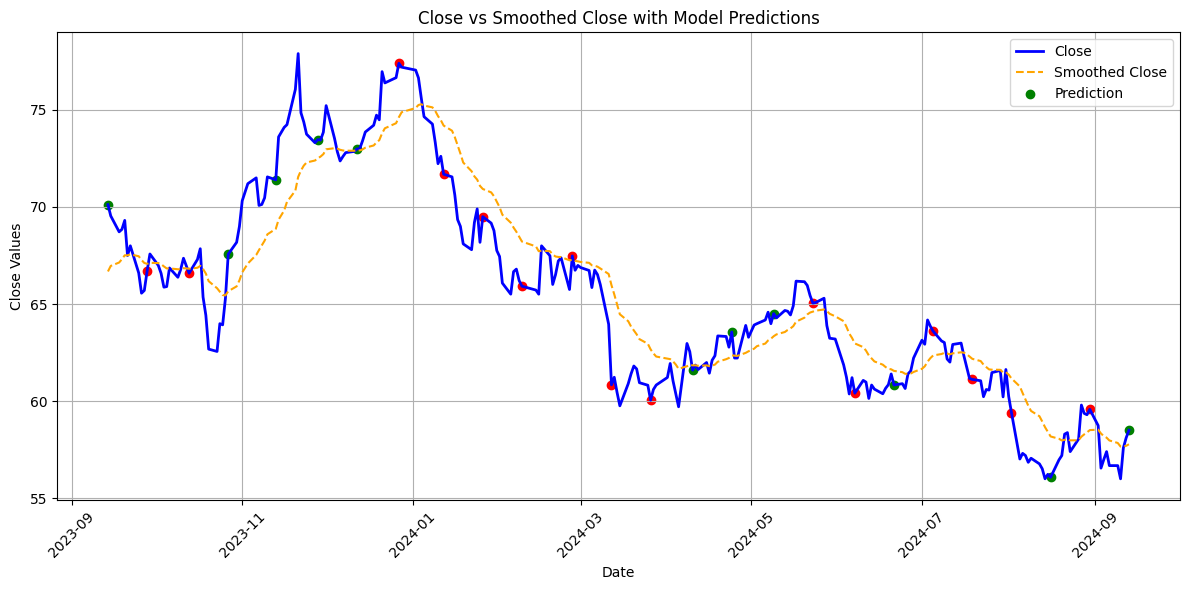

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Melhorando o modelo.

#### Vendos as features mais importantes.

In [202]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

RSI                     0.205691
Price_Rate_Of_Change    0.144954
MACD_EMA                0.144396
On Balance Volume       0.140836
MACD                    0.137365
k_percent               0.126945
r_percent               0.099812
dtype: float64

In [206]:
n_estimators = list(range(200, 2000, 200))

max_features = ['sqrt', None, 'log2']

max_depth = list(range(10, 110, 10))
max_depth.append(None)

min_samples_split = [2, 5, 10, 20, 30, 40]

min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [207]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

In [208]:
best_params = rf_random.best_params_

print("Melhores parâmetros encontrados:")
print(best_params)

Melhores parâmetros encontrados:
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


#### Usandos os melhores parâmetros. Não ficou melhor.

In [210]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier with the best parameters found
rand_frst_clf = RandomForestClassifier(
    n_estimators = 1200,        # Best parameter: 1200 estimators
    min_samples_split = 2,      # Best parameter: min_samples_split = 2
    min_samples_leaf = 2,       # Best parameter: min_samples_leaf = 2
    max_features = 'log2',      # Best parameter: max_features = 'log2'
    max_depth = 20,             # Best parameter: max_depth = 20
    bootstrap = True,           # Set bootstrap=True to enable out-of-bag estimation
    oob_score = True,           # Optionally keep oob_score if you want out-of-bag score
    criterion = "gini",        # Default criterion (can be changed if needed)
    random_state = 0
)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize=True) * 100.0)


Correct Prediction (%):  80.74935400516796


In [211]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.796432,0.750000,0.772519,2024.000000
Up Day,0.815194,0.851908,0.833147,2620.000000
accuracy,0.807494,0.807494,0.807494,0.807494
macro avg,0.805813,0.800954,0.802833,4644.000000
weighted avg,0.807017,0.807494,0.806723,4644.000000
